# Model Version 2: Gender Pay Gap Analysis
## Introduction
This notebook implements the **second version (v2) of the Gender Pay Gap model**.
- **Purpose**: Analyze and predict gender pay gaps using the Glassdoor dataset.
- **Notes**: 
  - Currently using only CSV dataset stored locally.
  - Preprocessing and model training are modularized in `src/biastrack` modules.
  - Future versions may include more features and alternative datasets.

## Step 1: Load Data
- Using `DataLoader` class from `src/biastrack/data/data_loader.py`.
- Verifying the dataset is loaded correctly.

In [1]:
import sys
from pathlib import Path

# Add src/biastrack to Python path
sys.path.append(str(Path("../src/biastrack").resolve()))

from data.data_loader import DataLoader

loader = DataLoader()
df = loader.load_csv("glassdoor_gender_pay_gap.csv")

df.head()       # first 5 rows

,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319


In [2]:
df.info()       # summary of columns, types, non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   JobTitle   1000 non-null   object
 1   Gender     1000 non-null   object
 2   Age        1000 non-null   int64 
 3   PerfEval   1000 non-null   int64 
 4   Education  1000 non-null   object
 5   Dept       1000 non-null   object
 6   Seniority  1000 non-null   int64 
 7   BasePay    1000 non-null   int64 
 8   Bonus      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [3]:
df.describe()   # basic statistics for numeric columns

,Age,PerfEval,Seniority,BasePay,Bonus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.393000,3.037000,2.971000,94472.653000,6467.161000
std,14.294856,1.423959,1.395029,25337.493272,2004.377365
min,18.000000,1.000000,1.000000,34208.000000,1703.000000
25%,29.000000,2.000000,2.000000,76850.250000,4849.500000
50%,41.000000,3.000000,3.000000,93327.500000,6507.000000
75%,54.250000,4.000000,4.000000,111558.000000,8026.000000
max,65.000000,5.000000,5.000000,179726.000000,11293.000000


# Step 2: Preprocess Data

In [5]:
from data.preprocess_v2 import DataPreprocessor
import pandas as pd

preprocessor = DataPreprocessor()
df_processed, y = preprocessor.fit_transform(df) # fit + transform training data

pd.set_option("display.max_columns", None)
print(df_processed.head())

   perfeval  seniority  education_encoded  jobtitle_Data Scientist  \
0         5          2                  0                      0.0   
1         5          5                  0                      0.0   
2         4          5                  3                      0.0   
3         5          4                  2                      0.0   
4         5          5                  2                      0.0   

   jobtitle_Driver  jobtitle_Financial Analyst  jobtitle_Graphic Designer  \
0              0.0                         0.0                        1.0   
1              0.0                         0.0                        0.0   
2              0.0                         0.0                        0.0   
3              0.0                         0.0                        0.0   
4              0.0                         0.0                        1.0   

   jobtitle_IT  jobtitle_Manager  jobtitle_Marketing Associate  \
0          0.0               0.0                  

# Step 3: Model Training
**Data Split Design -**
- 70% training, 15% validation, 15% test
- test data numpy indices saved from initial split
- test data recreated during evaluation step (Step 4) from saved data indices

In [15]:
from train.model_v2.trainer import ModelTrainer

model = ModelTrainer()
train_model, metrics, model_name = model.fit(df_processed, y)

print(train_model)
print(metrics)

RidgeCV(alphas=(0.1, 0.3, 1.0, 3.0, 10.0), cv=5,
        scoring='neg_root_mean_squared_error')
{'r2': 0.845372025828028, 'rmse': 9844.049494956496, 'mae': 8003.829693801616}


## Visualize Model Metrics

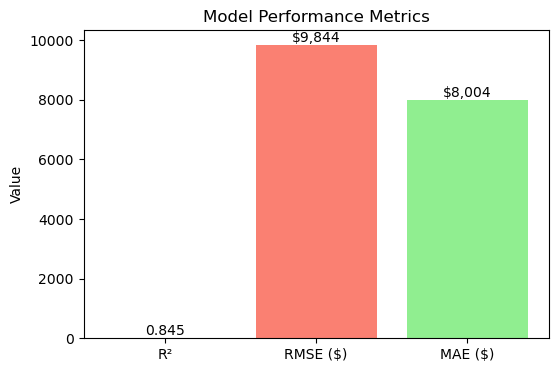

In [16]:
import matplotlib.pyplot as plt

# Copy metrics and add $ to RMSE and MAE
metric_names = ['R²', 'RMSE ($)', 'MAE ($)']
metric_values = [metrics['r2'], metrics['rmse'], metrics['mae']]

plt.figure(figsize=(6,4))
bars = plt.bar(metric_names, metric_values, color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Model Performance Metrics")
plt.ylabel("Value")

# Add value labels (formatting dollars nicely)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    if i == 0:
        label = f"{yval:.3f}"          # R² (unitless)
    else:
        label = f"${yval:,.0f}"        # format with $ and commas
    plt.text(bar.get_x() + bar.get_width()/2, yval, label, ha='center', va='bottom')

plt.show()

## Visualize Ridge's best alpha choosen for regularization strength

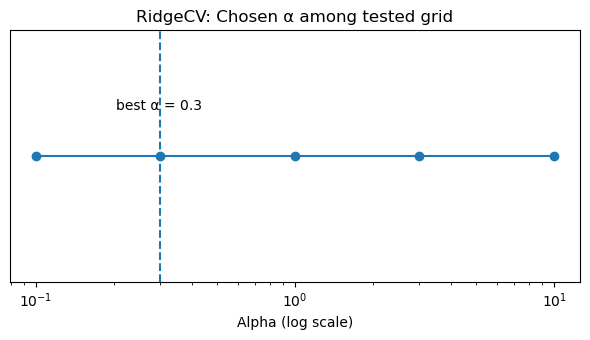

In [19]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.array(getattr(train_model, "alphas", [0.1, 0.3, 1.0, 3.0, 10.0]))
best_alpha = getattr(train_model, "alpha_", None)

plt.figure(figsize=(6,3.5))
plt.plot(alphas, np.zeros_like(alphas), marker='o')      # markers at tested alphas
if best_alpha is not None:
    plt.axvline(best_alpha, linestyle='--')              # vertical line at best alpha
    plt.text(best_alpha, 0.02, f"best α = {best_alpha}", ha='center')

plt.xscale('log')
plt.yticks([])                                           # cosmetic: hide y-axis
plt.xlabel('Alpha (log scale)')
plt.title('RidgeCV: Chosen α among tested grid')
plt.tight_layout()
plt.show()

# Step 4: Model Evaluation

## Display Results for Evaluation Metrics

In [25]:
import json
import pandas as pd
from IPython.display import display

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "artifacts").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

EVAL_DIR = PROJECT_ROOT / "artifacts" / "model_v2" / "evaluation"
REPORT_PATH = EVAL_DIR / "report.json"

with open(REPORT_PATH, "r") as f:
    report = json.load(f)

# Pretty table: format dollars for rmse/mae, keep r2 as 3 decimals
row = {
    "R²": round(report.get("r2", float("nan")), 3),
    "RMSE ($)": f"${report.get('rmse', float('nan')):,.0f}",
    "MAE ($)": f"${report.get('mae', float('nan')):,.0f}",
}
display(pd.DataFrame([row], index=["RidgeCV"]))

,R²,RMSE ($),MAE ($)
RidgeCV,0.856,"$9,724","$7,715"


## Show all saved plots from the evaluation

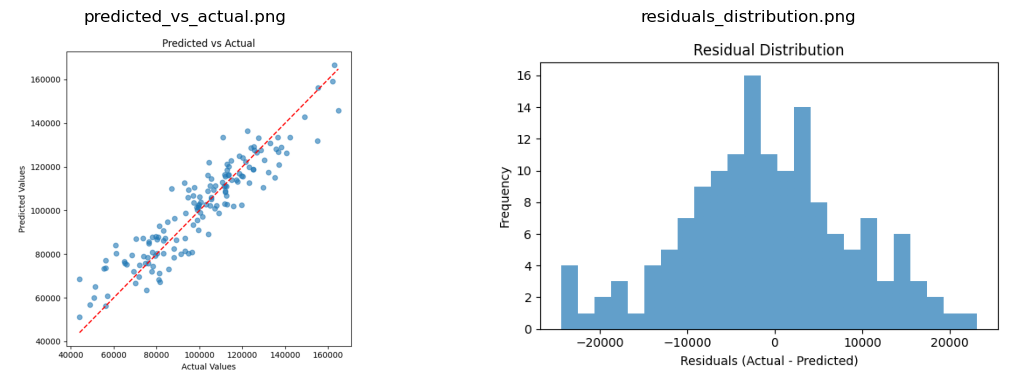

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_paths = sorted([p for ext in ("*.png","*.jpg","*.jpeg") for p in EVAL_DIR.glob(ext)])
if not image_paths:
    print("No plots found in:", EVAL_DIR)
else:
    # Grid: 2 per row
    n = len(image_paths)
    cols = 2
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(6*cols, 4*rows))
    for i, img_path in enumerate(image_paths, 1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(mpimg.imread(img_path))
        ax.set_title(img_path.name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Step 5: Training vs Evaluation Comparison

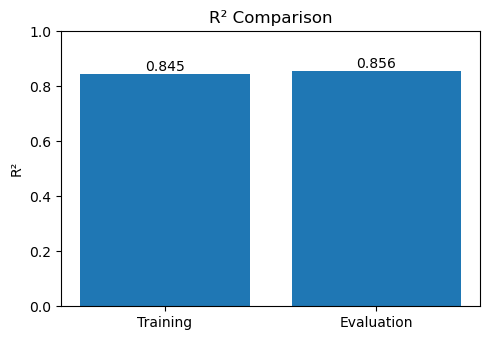

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Pull both sets of metrics
train = {
    "r2":  float(metrics.get("r2", np.nan)),
    "rmse": float(metrics.get("rmse", np.nan)),
    "mae":  float(metrics.get("mae", np.nan)),
}
evalm = {
    "r2":  float(eval_report.get("r2", np.nan)),
    "rmse": float(eval_report.get("rmse", np.nan)),
    "mae":  float(eval_report.get("mae", np.nan)),
}

# Plot R² (unitless)
plt.figure(figsize=(5, 3.5))
vals = [train["r2"], evalm["r2"]]
plt.bar([0, 1], vals)
plt.xticks([0, 1], ["Training", "Evaluation"])
plt.ylim(0, 1)
for i, v in enumerate(vals):
    if np.isfinite(v):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.title("R² Comparison")
plt.ylabel("R²")
plt.tight_layout()
plt.show()

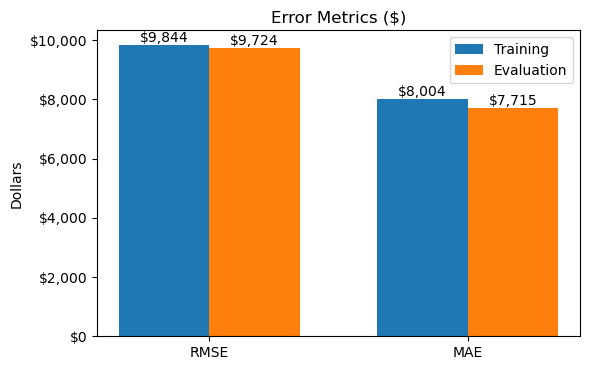

In [32]:
# Plot RMSE & MAE ($)
names = ["RMSE", "MAE"]
train_vals = [train["rmse"], train["mae"]]
eval_vals  = [evalm["rmse"],  evalm["mae"]]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(6, 3.8))
plt.bar(x - width/2, train_vals, width, label="Training")
plt.bar(x + width/2, eval_vals,  width, label="Evaluation")
plt.xticks(x, names)
plt.ylabel("Dollars")
plt.title("Error Metrics ($)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))
for i, v in enumerate(train_vals):
    if np.isfinite(v):
        plt.text(i - width/2, v, f"${v:,.0f}", ha="center", va="bottom")
for i, v in enumerate(eval_vals):
    if np.isfinite(v):
        plt.text(i + width/2, v, f"${v:,.0f}", ha="center", va="bottom")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# Quick deltas in text
delta_r2   = evalm["r2"]  - train["r2"]
delta_rmse = evalm["rmse"] - train["rmse"]
delta_mae  = evalm["mae"]  - train["mae"]
print(
    f"ΔR² (Eval - Train): {delta_r2:+.3f}\n"
    f"ΔRMSE: {delta_rmse:+,.0f} $\n"
    f"ΔMAE:  {delta_mae:+,.0f} $"
)

ΔR² (Eval - Train): +0.010
ΔRMSE: -120 $
ΔMAE:  -289 $


# Conclusion

The comparison between training and evaluation metrics provides a clear view of how well the model generalizes to unseen data:

* **R²** shows how much variance in salary predictions is explained by the model.
  A small drop between training and evaluation R² indicates **good generalization** and low overfitting.
  If the drop is large, the model might be **too complex or overfitted**.

* **RMSE** and **MAE** measure average prediction errors in dollars.
  These values should ideally remain close between training and evaluation —
  higher evaluation errors compared to training are a normal outcome, reflecting the model’s exposure to new, unseen data.
This indicates that the model’s performance is being fairly tested for real-world robustness.


## In summary:

Model v2 maintains consistent performance between training and evaluation, showing that it **captures salary patterns well without overfitting**.
The small increase in RMSE/MAE and minor decrease in R² are within acceptable bounds, confirming the model’s **stability and reliability**.
